### Figure S1: Basal melt rates

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cf_xarray
import cartopy.crs as ccrs
import cmocean as cm
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
from dask.distributed import Client
import matplotlib.path as mpath
import scipy as sp
import scipy.interpolate
import scipy.ndimage
import scipy.io
import scipy.stats
import pandas as pd
from pandas import DataFrame
import cartopy.feature as cft
from metpy.interpolate import cross_section
from pathlib import Path
import xgcm
from pyproj import Proj, transform
import pyproj
from datetime import datetime, timedelta
from xhistogram.xarray import histogram
import matplotlib.ticker as mticker
import intake

In [3]:
from dask.distributed import Client

client = Client(threads_per_worker=1)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.11/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.11/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.11/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that i

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/41331/status,
Dashboard: /proxy/41331/status,Workers: 28
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42409,Workers: 0
Dashboard: /proxy/41331/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:32999,Total threads: 1
Dashboard: /proxy/35095/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:44375,


In [4]:
# Load observational data

# Paolo melt rates
# Load melt datasets:
melt_dataset = xr.open_dataset('/g/data/jk72/or6852/ANT_G1920V01_IceShelfMelt.nc',engine='netcdf4')
# calculate lon and lat of the basal melt file \n",
inProj = Proj(init='epsg:3031')
outProj = Proj(init='epsg:4326')
bas_lon,bas_lat = transform(inProj,outProj,melt_dataset.melt_mean.x,melt_dataset.melt_mean.y)
x2d, y2d = np.meshgrid(melt_dataset.melt.x, melt_dataset.melt.y)
bas_lon2d,bas_lat2d = transform(inProj,outProj,x2d, y2d)
melt_dataset.coords['lat'] = (melt_dataset.melt_mean.dims, bas_lat2d)
melt_dataset.coords['lon'] = (melt_dataset.melt_mean.dims, bas_lon2d)
pib_meltid = melt_dataset.melt.where(melt_dataset.ID.isin([54,55, 56,181,182])).where(~np.isnan(melt_dataset.melt[-1,:,:])).mean({'x','y'})# IDs for Crosson, PIG, Cosgrove, Thwaites W, Thwaites E, 
as_meltid = melt_dataset.melt.where(melt_dataset.ID.isin([54,55,56, 57, 58, 59, 109,181,182])).where(~np.isnan(melt_dataset.melt[-1,:,:])).mean({'x','y'})# IDs for Crosson, PIG, Dosgrove, Dotson W, Getz, Abbot, Thwaites W, Thwaites E, 

# Davison melt rates
dav_pig = pd.read_csv('/g/data/jk72/or6852/ensoant/Pine_Island-timeseries.csv',parse_dates=[1])
dav_pig_melt = xr.DataArray(dav_pig['bm_monthly'],dims={'time':dav_pig.dates_datetime},coords={'time':dav_pig.dates_datetime,'area':dav_pig.area_km2[0]})
dav_abb = pd.read_csv('/g/data/jk72/or6852/ensoant/Abbot-timeseries.csv',parse_dates=[1])
dav_abb_melt = xr.DataArray(dav_abb['bm_monthly'],dims={'time':dav_abb.dates_datetime},coords={'time':dav_abb.dates_datetime,'area':dav_abb.area_km2[0]})
dav_cos = pd.read_csv('/g/data/jk72/or6852/ensoant/Cosgrove-timeseries.csv',parse_dates=[1])
dav_cos_melt = xr.DataArray(dav_cos['bm_monthly'],dims={'time':dav_cos.dates_datetime},coords={'time':dav_cos.dates_datetime,'area':dav_cos.area_km2[0]})
dav_cro = pd.read_csv('/g/data/jk72/or6852/ensoant/Crosson-timeseries.csv',parse_dates=[1])
dav_cro_melt = xr.DataArray(dav_cro['bm_monthly'],dims={'time':dav_cro.dates_datetime},coords={'time':dav_cro.dates_datetime,'area':dav_cro.area_km2[0]})
dav_dot = pd.read_csv('/g/data/jk72/or6852/ensoant/Dotson-timeseries.csv',parse_dates=[1])
dav_dot_melt = xr.DataArray(dav_dot['bm_monthly'],dims={'time':dav_dot.dates_datetime},coords={'time':dav_dot.dates_datetime,'area':dav_dot.area_km2[0]})
dav_get = pd.read_csv('/g/data/jk72/or6852/ensoant/Getz-timeseries.csv',parse_dates=[1])
dav_get_melt = xr.DataArray(dav_get['bm_monthly'],dims={'time':dav_get.dates_datetime},coords={'time':dav_get.dates_datetime,'area':dav_get.area_km2[0]})
dav_thw = pd.read_csv('/g/data/jk72/or6852/ensoant/Thwaites-timeseries.csv',parse_dates=[1])
dav_thw_melt = xr.DataArray(dav_thw['bm_monthly'],dims={'time':dav_thw.dates_datetime},coords={'time':dav_thw.dates_datetime,'area':dav_thw.area_km2[0]})
dav_conc = xr.concat([dav_pig_melt,dav_thw_melt,dav_cos_melt,dav_cro_melt,dav_abb_melt,dav_dot_melt,dav_get_melt],dim='IS')
dav_pib_melt = dav_conc[:4,:].weighted(dav_conc[:4,:].area).mean('IS')
dav_as_melt = dav_conc.weighted(dav_conc.area).mean('IS')

In [11]:
# Get the Adusumilli file for comparison
basal_meltrates = scipy.io.loadmat('/home/581/or6852/ice_shelf_change/data/figure_4/deep_shallow_melting.mat')
as_time = basal_meltrates['t']
as_meltr = basal_meltrates['wb_ra_amundsen']
as_meltstd = basal_meltrates['wb_ra_amundsen_std']

as_mr = np.concatenate((as_time,as_meltr,as_meltstd),axis=1) # make one array with 3 columns

#calculate annual means from seasonal data
as_mr_yr=as_mr[7:,:].reshape(25,4,3) # first 7 values are NaN, then 25 years of data
as_mr_yr=np.mean(as_mr_yr,axis=1)

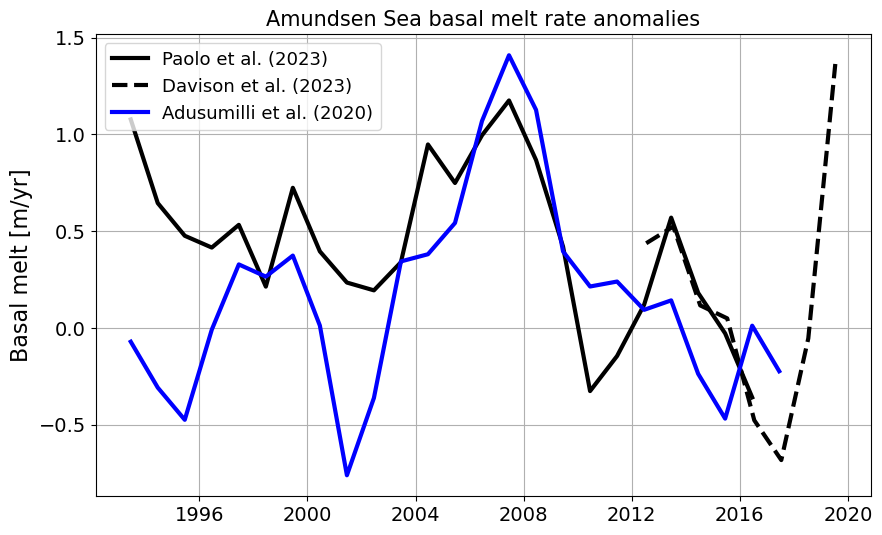

In [15]:
# Time series of temperature compared to Adusumilli melt rates: 
#Also get different temperature cycles in here
fig = plt.figure(figsize=(10,6))
ax1 = plt.axes()
# Basal melting on left yaxis: Relative to averages of overlapping period
(-as_meltid+as_meltid.sel(time=slice('2011-01-01','2017-12-31')).mean('time')).resample({'time':'Y'}).mean().assign_coords(time = as_meltid.time[1::4]).rolling(time=3,center=True).mean().plot(ax=ax1,color='k', lw=3, label='Paolo et al. (2023)')
# Davison
(dav_as_melt-dav_as_melt.sel(time=slice('2011-01-01','2017-12-31')).mean('time'))[8:-9].resample({'time':'Y'}).mean().assign_coords(time = dav_as_melt.time[6::12]).rolling(time=3,center=True).mean().plot(ax=ax1,color='k', lw=3, ls='--', label='Davison et al. (2023)')
# Adusumilli
ax1.plot(as_meltid.time[5::4],as_mr_yr[:,1]-np.nanmean(as_mr_yr[-8:-1,1]),color='b',lw=3,label='Adusumilli et al. (2020)')


ax1.grid()
ax1.set_ylabel('Basal melt [m/yr]', color ='k',fontsize=16)
ax1.tick_params('y', colors='k', labelsize=14)
ax1.tick_params('x', colors='k', labelsize=14)
ax1.set_title('Amundsen Sea basal melt rate anomalies', fontsize=15)
ax1.set_xlabel('')
ax1.legend(fontsize=13, loc= 'upper left')
#plt.savefig('/home/581/or6852/plots/figures/supplement_melt_rates_v2.png')